<a href="https://colab.research.google.com/github/VolkhinD/sentiment-_analysis/blob/main/sentiments_little.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
! pip install transformers

In [2]:
import warnings
warnings.filterwarnings('ignore')
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments
from sklearn.metrics import accuracy_score, classification_report
%matplotlib inline
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda', index=0)

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Data/sentiment_analysis/top_reviews.csv", usecols=[4, 3])
df = df.rename(columns={'content': 'comment'})

In [5]:
def to_sentiment(row):
  if row <= 2:
    return 0
  elif row == 3:
    return 1
  else:
    return 2
df.score = df.score.apply(to_sentiment)
class_names = df.score.unique()

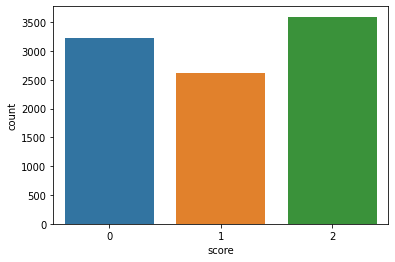

In [6]:
sns.countplot(df.score)

In [ ]:
model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
cls = pipeline('sentiment-analysis', model=model_name, tokenizer=tokenizer)


# Dataset, Dataloaders

In [8]:
class ClsData(Dataset):
  def __init__(self, df):
    self.df = df
    self.text = df.comment.to_numpy()
    self.label = df.score.to_numpy()
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    ans = tokenizer.encode_plus(self.text[index], padding=True, return_tensors='pt', truncation=True)
    return {
        'input_ids': ans['input_ids'].flatten(),
        'attention_mask': ans['attention_mask'].flatten(),
        'label': torch.tensor(self.label[index], dtype=torch.long)
    }



 I use **Dynamic padding** so each bath has it's own max lenngth, the length of longest sentence in a batch. To do that I remove 'sentence' key from Dataset dict beacause it doesn't work with text

In [9]:
data_collator = DataCollatorWithPadding(tokenizer)
train_valid, test = train_test_split(df, test_size=0.2, random_state=42)
train, valid = train_test_split(train_valid, test_size=0.25, random_state=42)
data = {'train': train, 'valid': valid, 'test': test}
data_len = {key: len(data[key]) for key in ['train', 'valid', 'test']}
ds_data = {key: ClsData(data[key]) for key in ['train', 'valid', 'test']}
dataloaders = {key: DataLoader(ds_data[key], batch_size=8, collate_fn=data_collator) for key in ['train', 'valid', 'test']}

In [10]:
for step, batch in enumerate(dataloaders['train']):
    print(batch["input_ids"].shape)
    if step > 5:
        break

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


torch.Size([8, 114])
torch.Size([8, 75])
torch.Size([8, 87])
torch.Size([8, 59])
torch.Size([8, 43])
torch.Size([8, 116])
torch.Size([8, 118])


# Training

## Hugging face API

In [11]:
training_args = TrainingArguments("test-trainer")

In [12]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=ds_data["train"],
    eval_dataset=ds_data["valid"],
    data_collator=data_collator,
    tokenizer=tokenizer,

)

I didn’t tell the Trainer to evaluate during training by setting evaluation_strategy to either "steps" (evaluate every eval_steps) or "epoch" (evaluate at the end of each epoch).
I didn’t provide the Trainer with a compute_metrics() function to calculate a metric during said evaluation (otherwise the evaluation would just have printed the loss, which is not a very intuitive number).

In [13]:
trainer.train()

***** Running training *****
  Num examples = 5670
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2127


Step,Training Loss
500,0.880200
1000,0.684000
1500,0.551400
2000,0.350700


Saving model checkpoint to test-trainer/checkpoint-500
Configuration saved in test-trainer/checkpoint-500/config.json
Model weights saved in test-trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-500/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1000
Configuration saved in test-trainer/checkpoint-1000/config.json
Model weights saved in test-trainer/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1500
Configuration saved in test-trainer/checkpoint-1500/config.json
Model weights saved in test-trainer/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1500/tokenizer_config.json
Special tokens file saved

TrainOutput(global_step=2127, training_loss=0.6003253041829197, metrics={'train_runtime': 415.9957, 'train_samples_per_second': 40.89, 'train_steps_per_second': 5.113, 'total_flos': 900416254723524.0, 'train_loss': 0.6003253041829197, 'epoch': 3.0})

In [14]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Models/sentiment_bert.pt")

In [15]:
predictions = trainer.predict(ds_data["test"])
print(predictions.predictions.shape, predictions.label_ids.shape)
preds = np.argmax(predictions.predictions, axis=-1)
preds

***** Running Prediction *****
  Num examples = 1891
  Batch size = 8


(1891, 3) (1891,)


array([2, 0, 2, ..., 1, 2, 1])

In [16]:
print(classification_report(test.score, preds))

              precision    recall  f1-score   support

           0       0.73      0.69      0.71       641
           1       0.51      0.49      0.50       547
           2       0.74      0.79      0.77       703

    accuracy                           0.67      1891
   macro avg       0.66      0.66      0.66      1891
weighted avg       0.67      0.67      0.67      1891

